# <center> Sched Lotka-Volterra and Replicator Models

---
## <center> Defined Needed Libraries 

In [26]:
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import warnings
import sys
from numba import jit

---
## <center> Lotka-Volterra Model

### Generate Lotka-Volterra Data
We generate synthetic data using the descrete dynamical model: Lotka-Voltera with specific parameters to use this data to check the accurecy of the fitting.

In [27]:
@jit(target_backend='cuda')
def discrete_lotka_volterra(x0, treatment, params):
    ''' 
    This function is to simulate the discrete Lotka-Volterra model with treatment
    x0: initial values of the populations
    treatment: the treatment for each time step
    params: parameters of the model
    show_plot: whether to show the plot of the simulation
    return: the populations of each type of cells
    '''
    r1, r2, r3, d12, d13, d21, d23, d31, d32, K, c1, c2, c3, m12, m13, m2, m3 = params # Parameters of the model
    i0, x10, x20 = x0 
    i1p, x1p, x2p = [], [], []
    for i in treatment:
        i_curr, x1_curr, x2_curr = i0, x10, x20    
        i11p, x11p, x22p = [], [], []
        for k in range(len(i)):
            x = x1_curr + x2_curr + i_curr
            f1 = i_curr / x  # frequency of immune cells
            f2 = x1_curr / x # frequency of cancer cells of type 1
            f3 = x2_curr / x # frequency of cancer cells of type 2
            di11 = i_curr * (r1 * f1 + d12 * f2 + d13 * f3) * (1 - x/K) - (c1 + c1 * 10**5 * i[k]) * i_curr - (m12 + m13) * i_curr
            dx11 = x1_curr * (d21 * f1 + r2 * f2 + d23 * f3) * (1 - x/K) - (c2 + c2 * 10**5 * i[k]) * x1_curr - m2 * x1_curr + m12 * i_curr + m3 * x2_curr
            dx22 = x2_curr * (d31 * f1 + d32 * f2 + r3 * f3) * (1 - x/K) - (c3 + c3 * 10**5 * i[k]) * x2_curr - m3 * x2_curr + m13 * i_curr + m2 * x1_curr
            i11p.append(i_curr), x11p.append(x1_curr), x22p.append(x2_curr)
            i_curr += di11
            x1_curr += dx11
            x2_curr += dx22
        i1p.append(i11p), x1p.append(x11p), x2p.append(x22p) # append the data for each treatment
    return i1p, x1p, x2p

## <center>Scheduling Policy of the Treatment for One Week

In [28]:
# Define the set of possible values of treatment vector
possible_values = [0, 1e-9, 1e-8, 1e-7, 1e-6 ,1e-5]

# Define the size of the vector
vector_size = 4

# Generate all possible vectors
Treatment_Matrix = list(itertools.product(possible_values, repeat=vector_size))

observations_horizon = 24  # n number of observations for each value of single treatment
Treatment_Matrix_Full = [[c[T] for T in range(len(c)) for k in range(observations_horizon)] for c in Treatment_Matrix]

x0 = [60.4551985, 56.1345208, 46.32307756]
warnings.filterwarnings('ignore')

In [29]:
param_lotka_volterra = [0.021559098618990413, 0.3638992363135647, 0.12416646036601348, 0.06615817725216783, 0.013514985040815886, 0.0004531528490355208, 0.023815874331617914, 0.00039553191230418117, 0.35062977191459116, 289.16646646551544, 0.02057544853617227, 0.05048121640922948, 0.12555071687967229, 0.0026343116464889182, 0.019094888915407948, 0.008933614483927821, 0.010243761836921883]
best = np.inf
i, x1, x2 = discrete_lotka_volterra(x0, Treatment_Matrix_Full, param_lotka_volterra)

In [30]:
counter = 0
for I in range(len(Treatment_Matrix_Full)):
    counter += 1
    sys.stdout.write(f"\rStep {counter}/{len(Treatment_Matrix_Full)}: Best objective value so far = {best}")
    i_predicted, x1_predicted, x2_predicted = np.array(i[I]), np.array(x1[I]), np.array(x2[I])

    i_sum, x1_sum, x2_sum = sum(i_predicted), sum(x1_predicted), sum(x2_predicted)
    Object = x1_sum + x2_sum - i_sum
    if Object < best:
        best = Object
        best_Treatment = Treatment_Matrix[I]
        best_i_predicted = i_predicted
        best_x1_predicted = x1_predicted
        best_x2_predicted = x2_predicted
    
    # Clear the previous line by printing a carriage return ('\r') and overwriting with new text
    sys.stdout.flush()
print('The best reatment is', best_Treatment, 'with the value of the objective function', best)

Step 1296/1296: Best objective value so far = 12909.507280149588The best reatment is (1e-05, 1e-05, 1e-05, 1e-05) with the value of the objective function 12238.788980876845


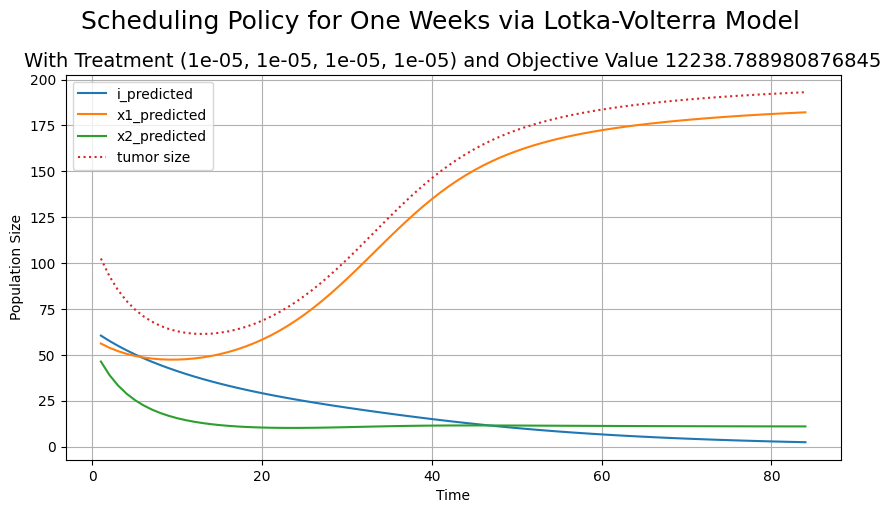

In [32]:
best_i_predicted, best_x1_predicted, best_x2_predicted = np.array(best_i_predicted[:84]), np.array(best_x1_predicted[:84]), np.array(best_x2_predicted[:84])
t= np.linspace(1, len(best_i_predicted), len(best_i_predicted))
plt.figure(figsize=(10, 5))
plt.plot(t, best_i_predicted, '-', label='i_predicted')
plt.plot(t, best_x1_predicted, '-', label='x1_predicted')
plt.plot(t, best_x2_predicted, '-', label='x2_predicted')
plt.plot(t, np.array(best_x1_predicted) + np.array(best_x2_predicted), ':', label='tumor size')
plt.xlabel('Time')
plt.ylabel('Population Size') 
plt.suptitle('Scheduling Policy for One Weeks via Lotka-Volterra Model', fontsize=18, y=1.01)
plt.title(f'With Treatment {best_Treatment} and Objective Value {best}', fontsize=14)
plt.grid()
plt.legend()
plt.show()

## <center>Scheduling Policy of the Treatment for Two Weeks

In [7]:
# Define the set of possible values of treatment vector
possible_values = [0, 1e-9, 1e-8, 1e-7, 1e-6 ,1e-5]
# Define the size of the vector
vector_size = 7
# Generate all possible vectors
Treatment_Matrix = list(itertools.product(possible_values, repeat=vector_size))
Treatment_Matrix_Full = [[c[T] for T in range(len(c)) for k in range(observations_horizon)] for c in Treatment_Matrix]

In [8]:
best = np.inf
i, x1, x2 = discrete_lotka_volterra(x0, Treatment_Matrix_Full, param_lotka_volterra)

In [9]:
counter = 0
for I in range(len(Treatment_Matrix_Full)):
    counter += 1
    sys.stdout.write(f"\rStep {counter}/{len(Treatment_Matrix_Full)}: Best objective value so far = {best}")
    i_predicted, x1_predicted, x2_predicted = np.array(i[I]), np.array(x1[I]), np.array(x2[I])
    i_sum, x1_sum, x2_sum = sum(i_predicted), sum(x1_predicted), sum(x2_predicted)
    Object = x1_sum + x2_sum - i_sum
    if Object < best:
        best = Object
        best_Treatment = Treatment_Matrix[I]
        best_i_predicted = i_predicted
        best_x1_predicted = x1_predicted
        best_x2_predicted = x2_predicted
    
    # Clear the previous line by printing a carriage return ('\r') and overwriting with new text
    sys.stdout.flush()
print('The best reatment is', best_Treatment, 'with the value of the objective function', best)

Step 279936/279936: Best objective value so far = 27032.415028923097The best reatment is (1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05) with the value of the objective function 26381.708530160406


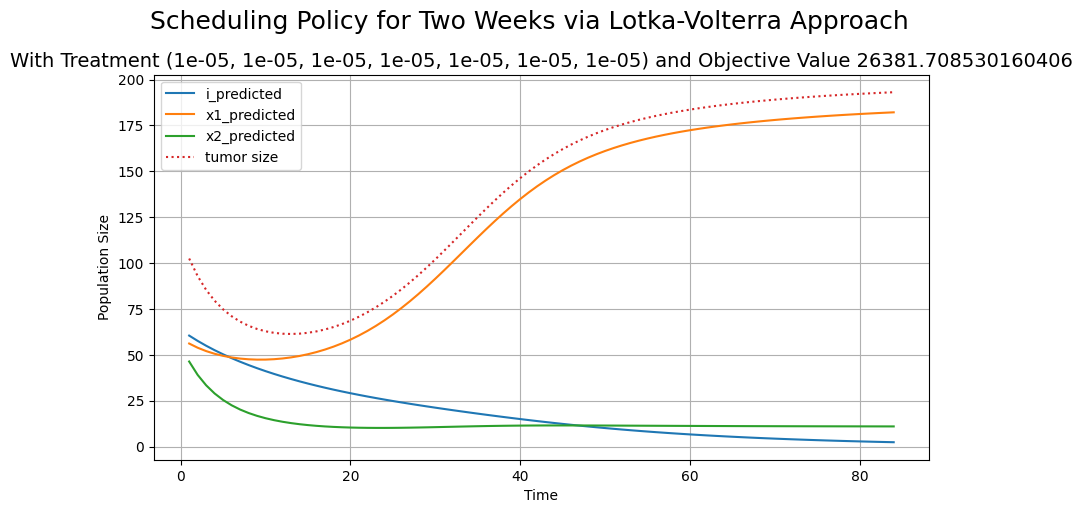

In [10]:
best_i_predicted, best_x1_predicted, best_x2_predicted = np.array(best_i_predicted[:84]), np.array(best_x1_predicted[:84]), np.array(best_x2_predicted[:84])
t= np.linspace(1, len(best_i_predicted), len(best_i_predicted))
plt.figure(figsize=(10, 5))
plt.plot(t, best_i_predicted, '-', label='i_predicted')
plt.plot(t, best_x1_predicted, '-', label='x1_predicted')
plt.plot(t, best_x2_predicted, '-', label='x2_predicted')
plt.plot(t, np.array(best_x1_predicted) + np.array(best_x2_predicted), ':', label='tumor size')
plt.xlabel('Time')
plt.ylabel('Population Size') 
plt.suptitle('Scheduling Policy for Two Weeks via Lotka-Volterra Approach', fontsize=18, y=1.01)
plt.title(f'With Treatment {best_Treatment} and Objective Value {best}', fontsize=14)
plt.grid()
plt.legend()
plt.show()